In [2]:
!uv init
!uv add scikit-learn fastapi uvicorn pandas numpy matplotlib scikit-imagen

Initialized project `working`
Using CPython 3.11.13 interpreter at: /usr/bin/python3
Creating virtual environment at: .venv
  × No solution found when resolving dependencies for split                         
  │ (python_full_version >= '3.12'):
  ╰─▶ Because scikit-imagen was not found in the package registry and your
      project depends on scikit-imagen, we can conclude that your project's
      requirements are unsatisfiable.
  help: If you want to add the package regardless of the failed resolution,
        provide the `--frozen` flag to skip locking and syncing.


In [3]:
!uv add scikit-image opencv-python

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
from tqdm import tqdm
import cv2
import warnings
warnings.filterwarnings('ignore')

Resolved 11 packages in 168ms                                        
⠙ Preparing packages... (0/10)                                                  ⠋ Preparing packages... (0/0)                                                   
⠙ Preparing packages... (0/10)---     0 B/64.91 KiB                     
packaging  ------------------------------     0 B/64.91 KiB
⠙ Preparing packages... (0/10)---     0 B/225.74 KiB                    
packaging  ------------------------------ 14.91 KiB/64.91 KiB
⠙ Preparing packages... (0/10)---     0 B/225.74 KiB                    
packaging  ------------------------------ 14.91 KiB/64.91 KiB
tifffile   ------------------------------     0 B/225.74 KiB
⠙ Preparing packages... (0/10)---     0 B/6.71 MiB                      
packaging  ------------------------------ 14.91 KiB/64.91 KiB
tifffile   ------------------------------     0 B/225.74 KiB
⠙ Preparing packages... (0/10)--- 14.94 KiB/6.71 MiB                    
packaging  -------------------------

In [4]:
# Configuration
DATA_DIR = "/kaggle/input/dogs-vs-cats-dataset"
TRAIN_DIR = os.path.join(DATA_DIR, "train", "train")
TEST_DIR = os.path.join(DATA_DIR, "test1", "test1")

# Model parameters
IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 32
FEATURE_DIM = 512  # Reduced feature dimension

print(f"Training images: {len(os.listdir(TRAIN_DIR))}")
print(f"Test images: {len(os.listdir(TEST_DIR))}")

# Sample file names
print("\nSample training files:")
print(os.listdir(TRAIN_DIR)[:10])

Training images: 25000
Test images: 12500

Sample training files:
['cat.12461.jpg', 'dog.3443.jpg', 'dog.7971.jpg', 'dog.10728.jpg', 'dog.1942.jpg', 'dog.375.jpg', 'cat.10176.jpg', 'cat.8194.jpg', 'dog.3259.jpg', 'cat.3498.jpg']


In [5]:
# Load pre-trained VGG16 model without top classification layers
base_model = VGG16(weights='imagenet', 
                   include_top=False, 
                   pooling='avg',
                   input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

# Freeze the base model
base_model.trainable = False

print("VGG16 model loaded successfully!")
print(f"Model summary:")
base_model.summary()

# Get the output dimension of features
sample_input = np.random.random((1, IMG_WIDTH, IMG_HEIGHT, 3))
sample_features = base_model.predict(sample_input)
print(f"\nFeature vector dimension: {sample_features.shape[1]}")

I0000 00:00:1761967114.783678      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761967114.784523      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
VGG16 model loaded successfully!
Model summary:


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

I0000 00:00:1761967117.463932     158 service.cc:148] XLA service 0x7d23b00058f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761967117.464622     158 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1761967117.464640     158 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1761967117.596581     158 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

Feature vector dimension: 512


I0000 00:00:1761967119.847943     158 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [6]:
def load_and_preprocess_images(image_paths, labels, target_size=(224, 224)):
    """
    Load and preprocess images for VGG16
    """
    images = []
    valid_labels = []
    
    for img_path, label in tqdm(zip(image_paths, labels), total=len(image_paths)):
        try:
            # Load image
            img = load_img(img_path, target_size=target_size)
            img_array = img_to_array(img)
            
            # Preprocess for VGG16
            img_array = preprocess_input(img_array)
            
            images.append(img_array)
            valid_labels.append(label)
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            continue
    
    return np.array(images), np.array(valid_labels)

def extract_features(model, images, batch_size=32):
    """
    Extract features using pre-trained model
    """
    features = model.predict(images, batch_size=batch_size, verbose=1)
    return features

In [7]:
# Get all image paths and labels
image_paths = []
labels = []

print("Loading image paths and labels...")
for filename in os.listdir(TRAIN_DIR):
    if filename.endswith('.jpg'):
        full_path = os.path.join(TRAIN_DIR, filename)
        image_paths.append(full_path)
        
        # Extract label from filename (cat or dog)
        if filename.startswith('cat'):
            labels.append(0)  # 0 for cat
        elif filename.startswith('dog'):
            labels.append(1)  # 1 for dog

print(f"Total images: {len(image_paths)}")
print(f"Cat images: {labels.count(0)}")
print(f"Dog images: {labels.count(1)}")

# Convert to numpy arrays
image_paths = np.array(image_paths)
labels = np.array(labels)

# Split into train and validation sets
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Training set: {len(train_paths)} images")
print(f"Validation set: {len(val_paths)} images")

Loading image paths and labels...
Total images: 25000
Cat images: 12500
Dog images: 12500
Training set: 20000 images
Validation set: 5000 images


In [8]:
# Get all image paths and labels
image_paths = []
labels = []

print("Loading image paths and labels...")
for filename in os.listdir(TRAIN_DIR):
    if filename.endswith('.jpg'):
        full_path = os.path.join(TRAIN_DIR, filename)
        image_paths.append(full_path)
        
        # Extract label from filename (cat or dog)
        if filename.startswith('cat'):
            labels.append(0)  # 0 for cat
        elif filename.startswith('dog'):
            labels.append(1)  # 1 for dog

print(f"Total images: {len(image_paths)}")
print(f"Cat images: {labels.count(0)}")
print(f"Dog images: {labels.count(1)}")

# Convert to numpy arrays
image_paths = np.array(image_paths)
labels = np.array(labels)

# Split into train and validation sets
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Training set: {len(train_paths)} images")
print(f"Validation set: {len(val_paths)} images")

Loading image paths and labels...
Total images: 25000
Cat images: 12500
Dog images: 12500
Training set: 20000 images
Validation set: 5000 images


In [9]:
# Load and preprocess training images
print("Loading and preprocessing training images...")
train_images, train_labels_processed = load_and_preprocess_images(
    train_paths[:2000], train_labels[:2000]  # Using subset for faster execution
)

print(f"Training images shape: {train_images.shape}")
print(f"Training labels shape: {train_labels_processed.shape}")

# Extract features
print("\nExtracting features from training images...")
train_features = extract_features(base_model, train_images)

print(f"Training features shape: {train_features.shape}")

Loading and preprocessing training images...


100%|██████████| 2000/2000 [00:11<00:00, 167.55it/s]


Training images shape: (2000, 224, 224, 3)
Training labels shape: (2000,)

Extracting features from training images...
63/63 ━━━━━━━━━━━━━━━━━━━━ 26s 258ms/step
Training features shape: (2000, 512)


In [10]:
# Load and preprocess validation images
print("Loading and preprocessing validation images...")
val_images, val_labels_processed = load_and_preprocess_images(
    val_paths[:500], val_labels[:500]  # Using subset for faster execution
)

print(f"Validation images shape: {val_images.shape}")
print(f"Validation labels shape: {val_labels_processed.shape}")

# Extract features
print("\nExtracting features from validation images...")
val_features = extract_features(base_model, val_images)

print(f"Validation features shape: {val_features.shape}")

Loading and preprocessing validation images...


100%|██████████| 500/500 [00:03<00:00, 156.41it/s]


Validation images shape: (500, 224, 224, 3)
Validation labels shape: (500,)

Extracting features from validation images...
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 703ms/step
Validation features shape: (500, 512)


In [11]:
# Standardize features
print("Standardizing features...")
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
val_features_scaled = scaler.transform(val_features)

print(f"Features standardized. Shape: {train_features_scaled.shape}")

# Apply PCA for dimensionality reduction (optional but recommended)
print("\nApplying PCA for dimensionality reduction...")
pca = PCA(n_components=FEATURE_DIM, random_state=42)
train_features_pca = pca.fit_transform(train_features_scaled)
val_features_pca = pca.transform(val_features_scaled)

print(f"Features after PCA: {train_features_pca.shape}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_.sum():.4f}")

Standardizing features...
Features standardized. Shape: (2000, 512)

Applying PCA for dimensionality reduction...
Features after PCA: (2000, 512)
Explained variance ratio: 1.0000


In [12]:
# Define SVM with hyperparameter tuning
print("Training SVM model with hyperparameter tuning...")

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
    'kernel': ['rbf', 'linear']
}

svm_model = svm.SVC(random_state=42, probability=True)

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    svm_model, 
    param_grid, 
    cv=3, 
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(train_features_pca, train_labels_processed)

print("SVM training completed!")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Get the best model
best_svm = grid_search.best_estimator_

Training SVM model with hyperparameter tuning...
Fitting 3 folds for each of 40 candidates, totalling 120 fits
SVM training completed!
Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation score: 0.9750


In [13]:
# Predict on validation set
print("Making predictions on validation set...")
val_predictions = best_svm.predict(val_features_pca)
val_probabilities = best_svm.predict_proba(val_features_pca)

# Calculate accuracy
val_accuracy = accuracy_score(val_labels_processed, val_predictions)
print(f"\n=== VALIDATION RESULTS ===")
print(f"Validation Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")

# Detailed classification report
print("\n=== CLASSIFICATION REPORT ===")
print(classification_report(val_labels_processed, val_predictions, 
                          target_names=['Cat', 'Dog']))

Making predictions on validation set...

=== VALIDATION RESULTS ===
Validation Accuracy: 0.9760 (97.60%)

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

         Cat       0.96      0.99      0.98       241
         Dog       0.99      0.97      0.98       259

    accuracy                           0.98       500
   macro avg       0.98      0.98      0.98       500
weighted avg       0.98      0.98      0.98       500



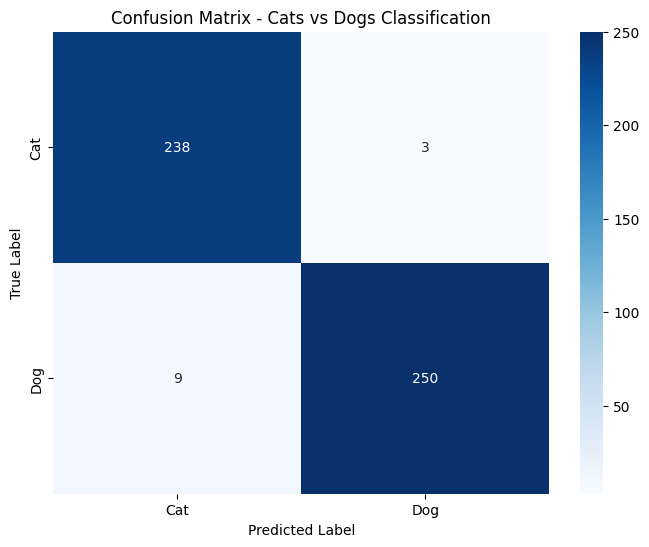

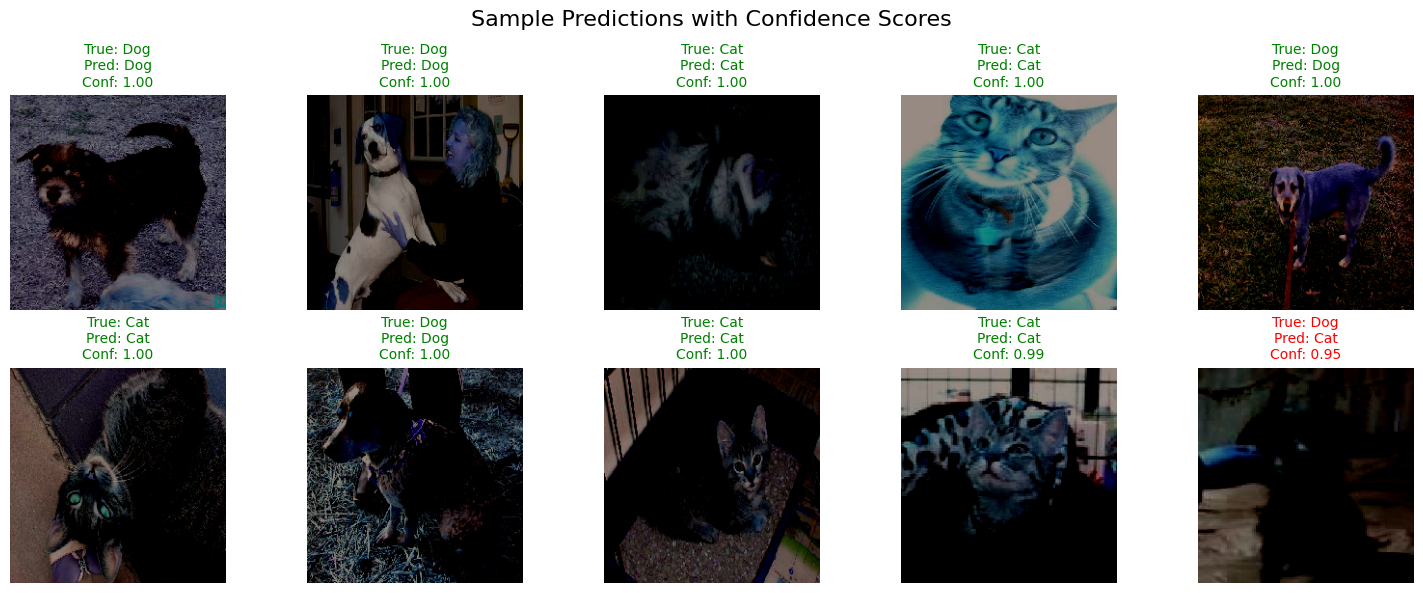

In [14]:
# Create confusion matrix
cm = confusion_matrix(val_labels_processed, val_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Cat', 'Dog'], 
            yticklabels=['Cat', 'Dog'])
plt.title('Confusion Matrix - Cats vs Dogs Classification')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot some sample predictions
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Sample Predictions with Confidence Scores', fontsize=16)

for i, ax in enumerate(axes.flat):
    if i < len(val_images):
        ax.imshow(val_images[i] / 255.0)  # Denormalize for display
        true_label = 'Cat' if val_labels_processed[i] == 0 else 'Dog'
        pred_label = 'Cat' if val_predictions[i] == 0 else 'Dog'
        confidence = val_probabilities[i].max()
        
        color = 'green' if true_label == pred_label else 'red'
        ax.set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}', 
                    color=color, fontsize=10)
        ax.axis('off')

plt.tight_layout()
plt.show()

Total misclassified images: 12
Error rate: 2.40%

=== ERROR ANALYSIS ===


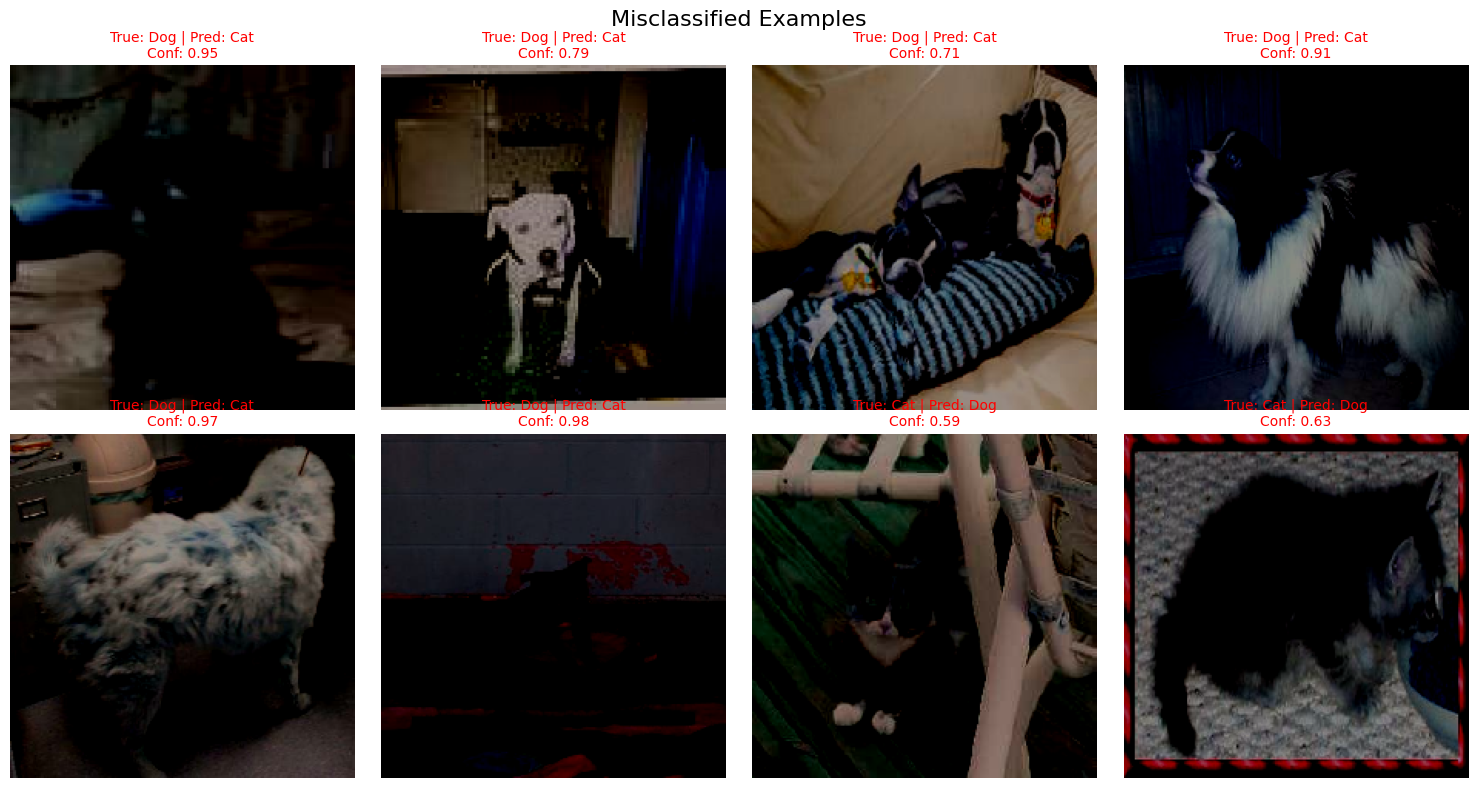


Cat misclassification rate: 1.24%
Dog misclassification rate: 3.47%


In [15]:
# Analyze misclassified images
misclassified_indices = np.where(val_predictions != val_labels_processed)[0]

print(f"Total misclassified images: {len(misclassified_indices)}")
print(f"Error rate: {len(misclassified_indices)/len(val_labels_processed)*100:.2f}%")

if len(misclassified_indices) > 0:
    print("\n=== ERROR ANALYSIS ===")
    
    # Show some misclassified examples
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    fig.suptitle('Misclassified Examples', fontsize=16)
    
    for i, ax in enumerate(axes.flat):
        if i < min(8, len(misclassified_indices)):
            idx = misclassified_indices[i]
            ax.imshow(val_images[idx] / 255.0)
            true_label = 'Cat' if val_labels_processed[idx] == 0 else 'Dog'
            pred_label = 'Cat' if val_predictions[idx] == 0 else 'Dog'
            confidence = val_probabilities[idx].max()
            
            ax.set_title(f'True: {true_label} | Pred: {pred_label}\nConf: {confidence:.2f}', 
                        color='red', fontsize=10)
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate error rates by class
    cat_errors = np.sum((val_labels_processed == 0) & (val_predictions != val_labels_processed))
    dog_errors = np.sum((val_labels_processed == 1) & (val_predictions != val_labels_processed))
    
    print(f"\nCat misclassification rate: {cat_errors/np.sum(val_labels_processed==0)*100:.2f}%")
    print(f"Dog misclassification rate: {dog_errors/np.sum(val_labels_processed==1)*100:.2f}%")

In [16]:
# Load and process test images
def predict_test_set(test_dir, model, feature_extractor, scaler, pca, sample_size=100):
    """
    Make predictions on the test set
    """
    test_files = [f for f in os.listdir(test_dir) if f.endswith('.jpg')]
    test_files = test_files[:sample_size]  # Limit for demonstration
    
    print(f"Processing {len(test_files)} test images...")
    
    test_images = []
    test_filenames = []
    
    for filename in tqdm(test_files):
        try:
            img_path = os.path.join(test_dir, filename)
            img = load_img(img_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
            img_array = img_to_array(img)
            img_array = preprocess_input(img_array)
            
            test_images.append(img_array)
            test_filenames.append(filename)
        except Exception as e:
            print(f"Error processing {filename}: {e}")
            continue
    
    test_images = np.array(test_images)
    
    # Extract features
    test_features = feature_extractor.predict(test_images, verbose=1)
    
    # Preprocess features
    test_features_scaled = scaler.transform(test_features)
    test_features_pca = pca.transform(test_features_scaled)
    
    # Make predictions
    test_predictions = model.predict(test_features_pca)
    test_probabilities = model.predict_proba(test_features_pca)
    
    return test_filenames, test_predictions, test_probabilities

test_filenames, test_preds, test_probs = predict_test_set(
    TEST_DIR, best_svm, base_model, scaler, pca, sample_size=100
)

# Create test results dataframe
test_results = pd.DataFrame({
    'filename': test_filenames,
    'prediction': ['cat' if pred == 0 else 'dog' for pred in test_preds],
    'confidence': test_probs.max(axis=1)
})

print(test_results.head(10))

Processing 100 test images...


100%|██████████| 100/100 [00:00<00:00, 171.90it/s]


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 998ms/step
    filename prediction  confidence
0   7981.jpg        dog    1.000000
1   6234.jpg        cat    0.970376
2   1269.jpg        dog    0.982574
3   3863.jpg        cat    0.999804
4   6241.jpg        dog    0.999999
5  10304.jpg        dog    1.000000
6    623.jpg        cat    0.999385
7   2193.jpg        cat    0.692557
8  11925.jpg        cat    0.993157
9   3750.jpg        dog    0.995719


In [17]:
# Final performance summary
print("=== MODEL PERFORMANCE SUMMARY ===")
print(f"Feature Extraction Model: VGG16")
print(f"Classifier: SVM ({best_svm.kernel} kernel)")
print(f"Feature Dimension: {FEATURE_DIM}")
print(f"Training Samples: {len(train_features_pca)}")
print(f"Validation Samples: {len(val_features_pca)}")
print(f"Validation Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
print(f"Best SVM Parameters: {grid_search.best_params_}")

# Calculate additional metrics
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(val_labels_processed, val_predictions)
recall = recall_score(val_labels_processed, val_predictions)
f1 = f1_score(val_labels_processed, val_predictions)

print(f"\n=== ADDITIONAL METRICS ===")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Save the trained model (optional)
import joblib
model_artifacts = {
    'svm_model': best_svm,
    'scaler': scaler,
    'pca': pca,
    'feature_extractor': base_model
}

joblib.dump(model_artifacts, 'svm_vgg16_cats_dogs.pkl')
print("\nModel artifacts saved successfully!")

=== MODEL PERFORMANCE SUMMARY ===
Feature Extraction Model: VGG16
Classifier: SVM (rbf kernel)
Feature Dimension: 512
Training Samples: 2000
Validation Samples: 500
Validation Accuracy: 0.9760 (97.60%)
Best SVM Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}

=== ADDITIONAL METRICS ===
Precision: 0.9881
Recall: 0.9653
F1-Score: 0.9766

Model artifacts saved successfully!
